<a href="https://colab.research.google.com/github/pjcroxas/ShortTermForecasting/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Lambda, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import SGD

from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir = "drive/MyDrive/Research/Short-term Forecasting/data/Benchmark"

In [3]:
rsp_df = pd.read_excel(dir+"/rsp_weather.xlsx")
rsp_df.head()

,Station,Date,Time Range,Entry,Exit,Weekday_Weekend,Year,Month,Time Index,Day,Calendar Day,temperature_2m (°C),showers (mm),datetime
0,North Edsa,2024-01-01,05:00 - 05:59,0,0,False,2024,1,5,2,1,31.2,0.0,2024-01-01 05:00:00
1,North Edsa,2024-01-01,06:00 - 06:59,397,154,False,2024,1,6,2,1,31.5,0.0,2024-01-01 06:00:00
2,North Edsa,2024-01-01,07:00 - 07:59,558,488,False,2024,1,7,2,1,31.6,0.0,2024-01-01 07:00:00
3,North Edsa,2024-01-01,08:00 - 08:59,630,537,False,2024,1,8,2,1,30.7,0.0,2024-01-01 08:00:00
4,North Edsa,2024-01-01,09:00 - 09:59,841,633,False,2024,1,9,2,1,29.8,0.0,2024-01-01 09:00:00


### I. Model using Timeseries only

In [28]:
rsp_only = rsp_df[['Year', 'Month', 'Time Index', 'Day', 'Calendar Day',"Entry", "Exit"]]
rsp_cols = list(rsp_only.columns)

In [4]:
def create_sliding_window(df, feature_cols, target_col, window_size):
    """
    Create sliding window sequences for time series models (e.g., LSTM).

    Parameters
    ----------
    df : pandas.DataFrame
        Time-ordered dataframe (do NOT shuffle).
    feature_cols : list
        Columns used as input features.
    target_col : str
        Column to predict.
    window_size : int
        Number of past timesteps in each window.

    Returns
    -------
    X : np.ndarray
        Shape: (samples, timesteps, features)
    y : np.ndarray
        Shape: (samples,)
    """
    X, y = [], []

    for i in range(window_size, len(df)):
        X.append(df[feature_cols].iloc[i - window_size:i].values)
        y.append(df[target_col].iloc[i])
        # print(X, y)

    return np.array(X), np.array(y)

In [39]:
X, y = create_sliding_window(rsp_only, rsp_cols, "Entry", 5)

Streaming output truncated to the last 5000 lines.
       [2024,    1,   16,    3,   16, 1843, 3100],
       [2024,    1,   17,    3,   16, 2097, 4443],
       [2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822]]), array([[2024,    1,   16,    3,   16, 1843, 3100],
       [2024,    1,   17,    3,   16, 2097, 4443],
       [2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822],
       [2024,    1,   20,    3,   16, 2701, 3021]]), array([[2024,    1,   17,    3,   16, 2097, 4443],
       [2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822],
       [2024,    1,   20,    3,   16, 2701, 3021],
       [2024,    1,   21,    3,   16,  987, 1879]]), array([[2024,    1,   18,    3,   16, 2193, 5603],
       [2024,    1,   19,    3,   16, 2566, 4822],
       [2024,    1,   20,    3,   16, 2701, 3021],
       [2024,    1,   21,    3,   16,  987, 1879],
       [2024,    1,    5,

In [45]:
X[1]

array([[2024,    1,    7,    2,    1,  558,  488],
       [2024,    1,    8,    2,    1,  630,  537],
       [2024,    1,    9,    2,    1,  841,  633],
       [2024,    1,   10,    2,    1, 1110,  788],
       [2024,    1,   11,    2,    1, 1412, 1145]])

In [46]:
y[1]

np.int64(1474)

In [12]:
def split_array(X, y, pct):
  # give the train set the first 70%
  train_size = int(len(X) * pct)
  X_train = X[:train_size]
  y_train = y[:train_size]

  X_test = X[train_size:]
  y_test = y[train_size:]

  return X_train, y_train, X_test, y_test

In [241]:
X_train, y_train, X_test, y_test = split_array(X, y, 0.7)

In [242]:
rng = np.random.default_rng(42)
indices = rng.permutation(len(X_train))
X_train_rand = X_train[indices]
y_train_rand = y_train[indices]

In [223]:
rsp_df.shape

(1521, 14)

In [10]:
def create_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=input_shape),
        # Dropout(0.2),
        # LSTM(50, activation='relu', return_sequences=False),
        Dense(30, activation="relu"),
        Dense(10, activation="relu"),
        Dense(1),
        Lambda(lambda x: x * 600)
    ])

    model.compile(loss='mae',
                  optimizer="adam")
    print("Model created!")
    return model

In [246]:
model = create_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model created!


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 100)            │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_29 (Lambda)              │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,551 (181.84 KB)

 Trainable params: 46,551 (181.84 KB)

 Non-trainable params: 0 (0.00 B)

In [247]:
history = model.fit(X_train_rand,
                    y_train_rand,
                    epochs=200,
                    batch_size=70,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/200
16/16 - 2s - 154ms/step - loss: 35831.7266 - val_loss: 20926.4629
Epoch 2/200
16/16 - 0s - 11ms/step - loss: 16114.7646 - val_loss: 12650.2227
Epoch 3/200
16/16 - 0s - 10ms/step - loss: 10421.7617 - val_loss: 9337.6064
Epoch 4/200
16/16 - 0s - 11ms/step - loss: 9535.0088 - val_loss: 9311.9268
Epoch 5/200
16/16 - 0s - 10ms/step - loss: 6822.2207 - val_loss: 6849.6802
Epoch 6/200
16/16 - 0s - 9ms/step - loss: 5476.3774 - val_loss: 5292.8379
Epoch 7/200
16/16 - 0s - 9ms/step - loss: 6036.5835 - val_loss: 6678.8306
Epoch 8/200
16/16 - 0s - 12ms/step - loss: 6754.4946 - val_loss: 7134.2388
Epoch 9/200
16/16 - 0s - 11ms/step - loss: 5648.7085 - val_loss: 4418.9551
Epoch 10/200
16/16 - 0s - 10ms/step - loss: 3913.2234 - val_loss: 3997.6821
Epoch 11/200
16/16 - 0s - 10ms/step - loss: 3755.6567 - val_loss: 3592.5308
Epoch 12/200
16/16 - 0s - 10ms/step - loss: 2975.5750 - val_loss: 3178.2024
Epoch 13/200
16/16 - 0s - 10ms/step - loss: 2598.1760 - val_loss: 2663.0110
Epoch 14/200
16/1

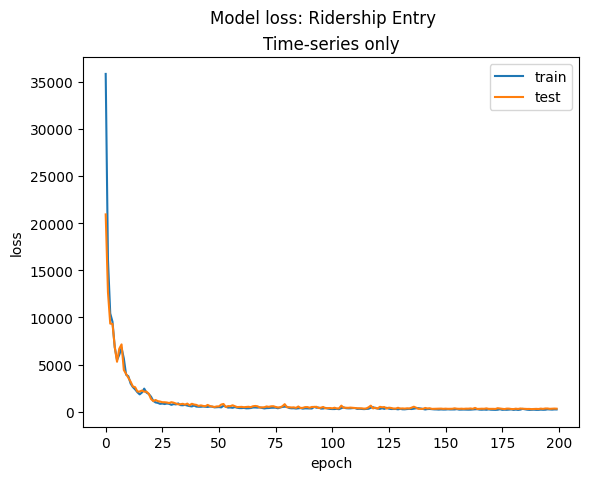

In [248]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.suptitle('Model loss: Ridership Entry')
plt.title("Time-series only")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [249]:
# Predict
forecast = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [24]:
# measure MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, forecast)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 497.1195983886719


### II. Model using weather data

In [95]:
rsp_df.columns

Index(['Station', 'Date', 'Time Range', 'Entry', 'Exit', 'Weekday_Weekend',
       'Year', 'Month', 'Time Index', 'Day', 'Calendar Day',
       'temperature_2m (°C)', 'showers (mm)', 'datetime'],
      dtype='object')

In [5]:
rsp_weather = rsp_df[['Year', 'Month', 'Time Index', 'Day', 'Calendar Day',"Entry", "Exit", "temperature_2m (°C)", "showers (mm)"]]
rsp_weather_cols = list(rsp_weather.columns)

In [6]:
X_w, y_w = create_sliding_window(rsp_weather, rsp_weather_cols, "Entry", 5)

In [7]:
rsp_weather

,Year,Month,Time Index,Day,Calendar Day,Entry,Exit,temperature_2m (°C),showers (mm)
0,2024,1,5,2,1,0,0,31.2,0.0
1,2024,1,6,2,1,397,154,31.5,0.0
2,2024,1,7,2,1,558,488,31.6,0.0
3,2024,1,8,2,1,630,537,30.7,0.0
4,2024,1,9,2,1,841,633,29.8,0.0
...,...,...,...,...,...,...,...,...,...
1692,2024,3,18,4,27,2504,4897,26.3,0.0
1693,2024,3,19,4,27,2430,3639,26.3,0.0
1694,2024,3,20,4,27,2255,2297,26.3,0.0
1695,2024,3,21,4,27,752,1845,26.2,0.0


In [15]:
# model_w = create_model((X_train.shape[1], X_train.shape[2]))
# model_w.summary()

In [13]:
X_train, y_train, X_test, y_test = split_array(X_w, y_w, 0.7)

In [45]:
model_w = create_model((X_train.shape[1], X_train.shape[2]))
model_w.summary()

Model created!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,351 (184.96 KB)

 Trainable params: 47,351 (184.96 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
rng = np.random.default_rng(42)
indices = rng.permutation(len(X_train))
X_train_rand = X_train[indices]
y_train_rand = y_train[indices]

In [46]:
history = model_w.fit(X_train_rand,
                    y_train_rand,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False,)

Epoch 1/100
24/24 - 3s - 108ms/step - loss: 32665.8340 - val_loss: 13461.8760
Epoch 2/100
24/24 - 0s - 11ms/step - loss: 11744.4150 - val_loss: 9621.1514
Epoch 3/100
24/24 - 0s - 12ms/step - loss: 6917.4824 - val_loss: 5005.0903
Epoch 4/100
24/24 - 0s - 11ms/step - loss: 4106.1299 - val_loss: 3045.0972
Epoch 5/100
24/24 - 0s - 11ms/step - loss: 2805.4922 - val_loss: 2285.5312
Epoch 6/100
24/24 - 0s - 11ms/step - loss: 2326.7349 - val_loss: 2227.8813
Epoch 7/100
24/24 - 0s - 12ms/step - loss: 2083.0979 - val_loss: 1951.5437
Epoch 8/100
24/24 - 0s - 12ms/step - loss: 1981.6508 - val_loss: 1868.0630
Epoch 9/100
24/24 - 0s - 12ms/step - loss: 1897.7838 - val_loss: 1868.3834
Epoch 10/100
24/24 - 0s - 11ms/step - loss: 1786.5192 - val_loss: 1855.1338
Epoch 11/100
24/24 - 0s - 12ms/step - loss: 1766.1216 - val_loss: 1756.6224
Epoch 12/100
24/24 - 0s - 11ms/step - loss: 1720.4302 - val_loss: 1769.1230
Epoch 13/100
24/24 - 0s - 11ms/step - loss: 1747.4841 - val_loss: 1714.7446
Epoch 14/100
24/2

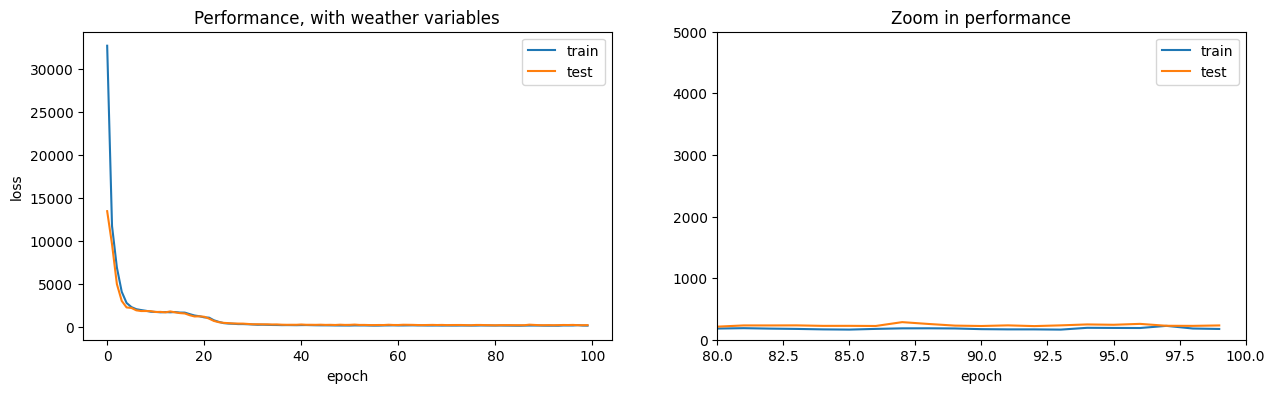

In [47]:
# plot the loss along the epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title("Performance, with weather variables")
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper right')

# Plot 2 zoom
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title("Zoom in performance")
# ax2.ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_xlim(80, 100)
ax2.set_ylim(0, 5000)
ax2.legend(['train', 'test'], loc='upper right')

In [48]:
# measure MAE
# Predict
forecast = model_w.predict(X_test)
mae = mean_absolute_error(y_test, forecast)
print(f"Mean Absolute Error: {mae}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Mean Absolute Error: 231.83082580566406


In [52]:
X_w[0]

array([[2.024e+03, 1.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 3.120e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 3.970e+02,
        1.540e+02, 3.150e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 7.000e+00, 2.000e+00, 1.000e+00, 5.580e+02,
        4.880e+02, 3.160e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 8.000e+00, 2.000e+00, 1.000e+00, 6.300e+02,
        5.370e+02, 3.070e+01, 0.000e+00],
       [2.024e+03, 1.000e+00, 9.000e+00, 2.000e+00, 1.000e+00, 8.410e+02,
        6.330e+02, 2.980e+01, 0.000e+00]])

In [195]:
model_dir = "drive/MyDrive/Research/Short-term Forecasting/model"

In [196]:
# save models
model.save(model_dir+"/model_ts.h5")
model_w.save(model_dir+"/model_w.h5")